# Testing the code on simulated noise

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code in comparison to the older `lalapps_pulsar_parameter_estimation` code when running on fake Gaussian noise. The former code uses [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) to sample the likelihood, whilst the latter can either use MCMC sampling of the posterior, or compute the posterior explicitly over a grid of point in the parameter space.

To do the comparisons both codes are run such that they divide the data up into "chunks" containing 30 points each (or less if required at the end of the data), with the data assumed stationary over those 30 points. However, the `lalapps_pulsar_parameter_estimation_nested` can also be run in a way that allows it to actually calculate the length of stationary data chunks.

In [1]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
from scipy.signal import fftconvolve
import subprocess as sp
import os
import sys
from time import time
import matplotlib as mpl
from matplotlib import pyplot as pl

# these modules require lalapps
from lalapps.pulsarpputils import *

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [2]:
# define a function to work out how many effective (uncorrelated) samples the MCMC chains contain
def independent_samples(d):
    # get independent samples from the matrix d, where d contains an MCMC chain over a number of parameters.
    # The maximum autocorrelation length of all the parameter is used to define the number of effective samples.
    M = 5.
    K = 2.

    neff = []
    for par in d.T:
        x = par - np.mean(par)
        y = np.conj(x[::-1])
        z = fftconvolve(y, x, 'full')
        z = np.fft.ifftshift(z)
        acf = z[0:len(par)]
        acf = acf/acf[0]

        # estimate the autocorrelation length
        acf[1:] = acf[1:]*2.
        imax = int(len(acf)/K)
        cacf = np.cumsum(acf)
        s = np.arange(1, len(cacf)+1, dtype=np.float64)/float(M)
        idxs = np.flatnonzero(cacf[:imax] < s[:imax])
        if len(idxs) == 0:
            acl = 1
        else:
            acl = s[idxs[0]]
        neff.append(np.floor(len(par)/acl))

    minneff = int(np.min(neff))

    return d[np.random.permutation(d.shape[0])[0:minneff],:]

In [3]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O1' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
ppeexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. I output a comparison plot between the posteriors produced for each realisation. I compare the upper limit produced from the nested-sampling-generated posterior and that calculated from the grid-based posterior. I also compare the run times for each implementation of the codes.

In [4]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {}
DECJ {}
F0 123.4567890
PEPOCH 56789.0
EPHEM DE405
"""

# some defaults for the data generation
sigma = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 900000000   # GPS start time of data
duration = 864000      # duration of data (seconds) - 10 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 10.8*np.sqrt(sigma**2/dlen)

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# (PHI0 in here is rotational phase, whereas for the older code it is GW phase for trixial emission l=m=2)
priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform {} {}
COSIOTA uniform -1 1
"""
fp = open(priorfile, 'w')
# set the h0 upper range to be 6 times the expected upper limit 
fp.write(priordat.format(ulest*6., np.pi, -np.pi/4., np.pi/4.))
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '2048' # number of nested sample live points

# lalapps_pulsar_parameter_estimation (MCMC) run parameters
iterations = '250000' # number of MCMC iterations after burn-in
burnin = '100000'     # number of MCMC iterations for burn-in

# lalapps_pulsar_parameter_estimation (grid) run parameters
h0steps = '80' # number of grid points for each parameter
psisteps = '40'
phi0steps = '40'
cosiotasteps = '40'
h0max = '%.5e' % (6.*ulest) # maximum range of h0 values
h0ulc = '95'                # % credible h0 upper limit to output

In [6]:
# create data
data = sigma*np.random.randn(dlen, 2)

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    
# create a random sky position from a uniform distribution on the sky
rah, ram, ras = rad_to_hms(2.*np.pi*np.random.rand())
decd, decm, decs = rad_to_dms(np.arccos(-1.+2.*np.random.rand()) - np.pi/2.)
    
# output .par file containing right ascension and declination
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), coord_to_string(decd, decm, decs)))
fp.close()
    
# run lalapps_pulsar_parameter_estimation_nested
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--oldChunks'])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timenested = (t1-t0)

# nested samples need to be converted to posterior samples with lalapps_nest2pos
if os.path.isfile(os.path.join(outdir, 'fake_post.hdf')):
    os.remove(os.path.join(outdir, 'fake_post.hdf'))
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post.hdf'),
                     os.path.join(outdir, 'fake_nest.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post.hdf'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))
    
h0ulnested = (h0ul)
evratnested = (evsig-evnoise)
    
# run lalapps_pulsar_parameter_estimation in MCMC mode
codecall = ' '.join([ppeexec, '--detectors', detector,
                     '--pulsar', psrname, '--par-file', parfile, '--input-dir', rundir,
                     '--output-dir', outdir, '--mcmc', '--iterations', iterations,
                     '--burn-in', burnin, '--psi-bins', '1000', '--time-bins', '1440'])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timemcmc = (t1-t0)

# run lalapps_pulsar_parameter_estimation in grid mode
# delete any previously created evidence file as things get appended to it
evfile = os.path.join(outdir, 'evidence_%s' % psrname)
if os.path.isfile(evfile):
    os.remove(evfile)

codecall = ' '.join(['lalapps_pulsar_parameter_estimation', '--detectors', detector,
                     '--pulsar', psrname, '--par-file', parfile, '--input-dir', rundir,
                     '--output-dir', outdir, '--psi-bins', '1000', '--time-bins', '1440',
                     '--h0steps', h0steps, '--maxh0', h0max, '--phi0steps', phi0steps,
                     '--psisteps', psisteps, '--cisteps', cosiotasteps, '--dob-ul', h0ulc])
    
t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timegrid = (t1-t0)

# read in evidence ratio and h0 upper limit produced by grid
evfile = os.path.join(outdir, 'evidence_%s' % psrname)
# evidence at end of first line, UL at end of second
fp = open(evfile, 'r')
evlines = fp.readlines()
h0ulgrid = float((evlines[1].split())[-1])
evratgrid = float((evlines[0].split())[-1])

# correct evidence and lalapps_pulsar_parameter_estimation does not apply the h0 and cos(iota) priors
# and also account for lalapps_pulsar_parameter_estimation using a 2pi phi0 range rather than pi
evratgrid = evratgrid - np.log(6.*ulest) - np.log(2.) + np.log(np.pi)

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'PHI0VECTOR', 'PHI22', 'PEPOCH', 'FREQNUM', 'PHI21', 'C21', 'DEC', 'PMRA', 'HPLUS', 'I31', 'Q22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']


In [7]:
# COMMENTED OUT FOR SPEED (although this gives identical results to using lalapps_pulsar_parameter_estimation in
# its grid-based mode)
# use the grid-based python script to double check
#datacomp = {detector: data[:,0] + 1j*data[:,1]}
#tsdic = {detector: gpstimes}
#ra = 0.0
#dec = 0.0

#paramranges = {'h0': (0., float(h0max), int(h0steps)),
#               'psi': (-np.pi/4., np.pi/4., int(psisteps))}

#t0 = time()
#L, h0pdf, phi0pdf, psipdf, cosiotapdf, lingrid, evrat = pulsar_posterior_grid(detector, tsdic, datacomp, ra, dec, paramranges=paramranges)
#t1 = time()

#print("Python grid-mode took %f s" % (t1-t0))
#print("Evidence ratio = %.12e" % evrat)

#pygrid = {'h0': np.vstack((lingrid['h0'], h0pdf)).T,
#          'phi': np.vstack((lingrid['phi0'], phi0pdf)).T,
#          'psi': np.vstack((lingrid['psi'], psipdf)).T,
#          'ciota': np.vstack((lingrid['cosiota'], cosiotapdf)).T}

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'PHI0VECTOR', 'PHI22', 'PEPOCH', 'FREQNUM', 'PHI21', 'C21', 'DEC', 'PMRA', 'HPLUS', 'I31', 'Q22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Number of independent MCMC samples is 6127 from 250000


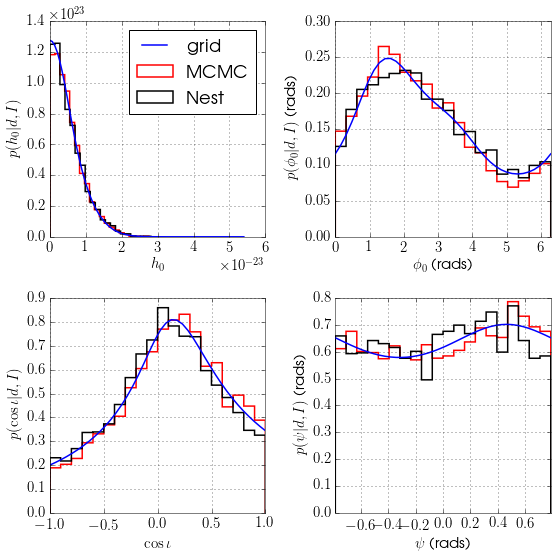

In [8]:
f, axarr = pl.subplots(2, 2, figsize=(8,8))

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post.hdf'))
postppemcmc = np.loadtxt(os.path.join(outdir, 'MCMCchain_%s_%s' % (psrname, detector)), comments='%')

# get independent MCMC samples
postmcmcind = independent_samples(postppemcmc[:,1:])
ppemcmcidxs = {'h0': 0, 'phi0': 1, 'cosiota': 2, 'psi': 3}
print("Number of independent MCMC samples is %d from %s" % (postmcmcind.shape[0], postppemcmc.shape[0]))

xlabels = {'h0': '$h_0$', 'phi0': '$\phi_0$ (rads)', 'cosiota': '$\cos{\iota}$', 'psi': '$\psi$ (rads)'}
ylabels = {'h0': '$p(h_0|d,I)$', 'phi0': '$p(\phi_0|d,I)$ (rads)', 'cosiota': '$p(\cos{\iota}|d,I)$', 'psi': '$p(\psi|d,I)$ (rads)'}

arr = {'h0': axarr[0, 0], 'phi0': axarr[0,1], 'cosiota': axarr[1,0], 'psi': axarr[1,1]}
lims = {'h0': [0., None], 'phi0': [0., 2.*np.pi], 'cosiota': [-1., 1.], 'psi': [-np.pi/4., np.pi/4.]}
gridparnames = {'h0': 'h0', 'phi0': 'phi', 'psi': 'psi', 'cosiota': 'ciota'}
for par in ['h0', 'phi0', 'psi', 'cosiota']:
    parscale = 1.
    if par == 'phi0': # for the nested sampling output scale PHI0 by two to make it GW phase rather than rotational phase
        parscale = 2.

    gridpdf = np.loadtxt(os.path.join(outdir, 'pdf_%s.%s.%s' % (gridparnames[par], psrname, detector)))

    arr[par].plot(gridpdf[:,0], gridpdf[:,1], 'b', linewidth=1.5)
    arr[par].hist(postmcmcind[:,ppemcmcidxs[par]], bins=20, normed=True, color='r', linewidth=1.5, histtype='step')
    arr[par].hist(postppen[0][par].samples*parscale, bins=20, normed=True, color='k', linewidth=1.5, histtype='step')

    arr[par].set_xlabel(xlabels[par])
    arr[par].set_ylabel(ylabels[par])

    if par == 'h0':
        #arr[par].legend(['grid 1', 'grid 2', 'MCMC', 'Nest'], loc=1)
        arr[par].legend(['grid', 'MCMC', 'Nest'], loc=1)
        xmin, xmax = arr[par].get_xlim()
        arr[par].set_xlim([lims[par][0], xmax])
    else:
        arr[par].set_xlim(lims[par])

pl.tight_layout()

In [9]:
print("Difference in upper limits:")
print("h0 upper limit (nested) = %.2e" % h0ulnested)
print("h0 upper limit (grid) = %.2e" % h0ulgrid)
print("percentage difference = %.2f" % (100.*np.abs(h0ulnested-h0ulgrid)/h0ulnested))
print("\n")
print("Difference in evidence ratios:")
print("log(evidence ratio) (nested) = %.2e" % evratnested)
print("log(evidence ratio) (grid) = %.2e" % evratgrid)
print("absolute difference = %.2f" % (np.abs(evratnested-evratgrid)))

Difference in upper limits:
h0 upper limit (nested) = 1.41e-23
h0 upper limit (grid) = 1.36e-23
percentage difference = 3.48


Difference in evidence ratios:
log(evidence ratio) (nested) = -1.97e+00
log(evidence ratio) (grid) = -1.93e+00
absolute difference = 0.04
